In [1]:
import torch
import pyro
import pyro.distributions as dist
import matplotlib.pyplot as plt
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from torch.distributions import constraints
import seaborn as sns
import numpy as np

import warnings
warnings.filterwarnings('ignore')
plt.style.use('dark_background')

## Bayesian inference

- y : observed variable
- z : latent

We assume the form  $P({\bf y} | {\bf z})$, data given the parameter. And suppose that we have some prior information about ${\bf z}$ : $P({\bf z})$.

What we are interested in is $\mathbb{E}_{P({\bf z} | {\bf y})} [ h(z)]$ and more generally $P({\bf z} | {\bf y})$.

Using Bayes rule:

$P({\bf z} | {\bf y}) = \frac{P({\bf y} | {\bf z}) P({\bf z})} {\int dz' P({\bf y} | {\bf z'}) P({\bf z'})}$



Sometimes it is possible to arrive to analytical result, cf. conjugate prior.
For example when both $P({\bf y} | {\bf z})$ and $P({\bf z})$ normal distributions.

And if not? Then use approximate methods.

There are two options: MCMC and Variational.

### MCMC
Create a finite sample:

$
\mathbb{E}_{P({\bf z} | {\bf y})} [ h(z)] 
\approx \frac{1}{N} \sum h({\bf z_k})
$

Markov chain - create a sequence of $(z_1, z_2, \cdots )$.

How? Using a kernel $K(z, z_t)$, for example use an autoregressive kernel $z_{t+1} \sim N(z_t, 1)$.

Algorithm sketch:

1. Sample $\hat z \sim K(z | z_t)$
2. Accept $\hat z$ as $ z_{t+1}$ with probability $\alpha = \min \left[1, \frac{ P({\bf \hat z} | {\bf y}) K(z_t | \hat z) }{P({\bf z_t} | {\bf y}) K(\hat z | z_t)} \right]$

We want the expectation to exist $ \mathbb{E}_{P({\bf z} | {\bf y})} $ and that is guaranteed if the chain is ergodic (aperiodic, irreducible and has a stationary distribution).

## Variational inference

Rather than creating a sample of ${\bf z}$, use a parametric function $Q({\bf z})$ that may or may not be the same functionally as $P({\bf z})$.

We take the challenge to maximize $P({\bf y})$ and minimize the distance between $Q({\bf z})$ and $P({\bf z} | {\bf y})$.

$\log P(y) - KL(Q||P)$?

$KL (Q||P) = \int dQ \log \frac{Q}{P}$

$\log P(y) - KL(Q||P)$?

$ \log P(y) = \log \frac{P(y, z)}{P(z)}$

$P(y) - KL(Q||P) = \int dQ \left( \log P(y)  - \log \frac{Q(z)}{P(z)} \right ) = \int dQ \left( \log \frac{P(y, z)}{P(z)}  - \log \frac{Q(z)}{P(z)} \right ) = \int dQ \left( \log P(y, z)  - \log Q(z) \right ) = \mathbb{E}_{Q_\phi} \left[ \log P(y, z) - \log Q(z) \right]$

Evidence lower bound:

$ELBO = \mathbb{E}_{Q_\phi} \left[ \log P_\theta(y, z) - \log Q_\phi(z) \right]$

Taking the gradient of ELBO is tricky, but possible.

## Point of view of pytorch
<table>
<tr>
<td> Variational GM </td>
<td> Torch Compute graph </td>
</tr>
<tr>
<td> <img src="img/var_gm.png" alt="Drawing" style="width: 100px;"/> </td>
<td> <img src="img/torch_cg.png" alt="Drawing" style="width: 100px;"/> </td>
</tr></table>

```python 
import torch 

a = torch.randn((3), requires_grad = True)
b = torch.randn((3), requires_grad = True)

c = a + b
print("grad fn for a is", a.grad_fn)
print("grad fn for c is", c.grad_fn)
>>>
grad fn for a is None
grad fn for c is <AddBackward0 object at 0x7fe9081e1e90>
```

And thus the computation graph is created and there are two steps:
- forward pass to compute the value of the loss function.
- backward pass to compute the gradients of the learnable parameters. 

## Pyro objects
 
- constants : `alpha0 = torch.tensor(10.)`

- parameters : `pyro.param("alpha_q", torch.tensor(10.), constraint=constraints.positive)`

- latent variables : `pyro.sample("nu", dist.Beta(alpha0, beta0))`

- observables : `pyro.sample('obs', dist.Bernoulli(f), obs=data)`

In [2]:
def lr_model(data, verbose=False):
    x_data, y_data = data
    slope_loc = torch.tensor(0.0)
    slope_scale = torch.tensor(1.0)
    bias_loc = torch.tensor(1.0)
    bias_scale = torch.tensor(1.0)
    sigma = torch.tensor(0.2)
    slope = pyro.sample("slope", dist.Normal(slope_loc, slope_scale))
    bias = pyro.sample("bias", dist.Normal(bias_loc, bias_scale))
    if verbose:
        print(f"in model: ")
        print(f"slope: {slope:.4f}")
        print(f"bias: {bias:.4f}")
        print(f"sigma: {sigma:.4f}")
    y_obs = pyro.sample(f"obs",
                        dist.Normal(slope * x_data + bias, sigma),
                        obs=y_data)
    return torch.stack([x_data, y_obs])

def lr_guide(data, 
             init_slope_loc=0.0,
             init_slope_scale=0.2,
             init_bias_loc=0.0,
             init_bias_scale=0.2,
             verbose=False
            ):
    x_data, y_data = data
    slope_loc = pyro.param("slope_loc", torch.tensor(init_slope_loc))
    slope_scale = pyro.param("slope_scale", torch.tensor(init_slope_scale), 
                             constraints.positive)
#     slope_scale = torch.tensor(init_slope_scale)
    bias_loc = pyro.param("bias_loc", torch.tensor(init_bias_loc))
    bias_scale = pyro.param("bias_scale", torch.tensor(init_bias_scale), 
                            constraints.positive) 
#     bias_scale = torch.tensor(init_bias_scale)
    slope = pyro.sample("slope", dist.Normal(slope_loc, slope_scale))
    bias = pyro.sample("bias", dist.Normal(bias_loc, bias_scale))
    if verbose:
        print(f"in model: ")
        print(f"slope: {slope:.4f}")
        print(f"bias: {bias:.4f}")
        print(f"sigma: {sigma:.4f}")

in model: 
slope: -1.4693
bias: 1.6935
sigma: 0.2000


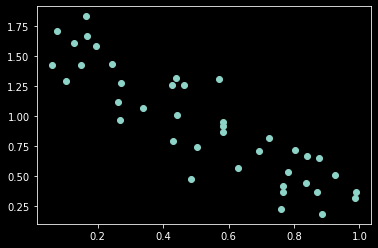

In [3]:
pyro.clear_param_store()
seed = 11
n = 40
n_pieces = 2
pyro.set_rng_seed(seed)
torch.manual_seed(seed)
data_gen = torch.rand(n), torch.rand(n)
data = pyro.poutine.uncondition(lr_model)(data_gen, True).detach()
plt.scatter(data[0], data[1])

In [4]:
gen_data_par = {
    "slope": -1.4693,
    "bias": 1.6935,
}

[iteration 0000] loss: 1012.384
[iteration 0050] loss: 23.964
[iteration 0100] loss: 1.684
[iteration 0150] loss: 3.169
[iteration 0200] loss: 1.731
[iteration 0250] loss: 9.026
[iteration 0300] loss: 3.306


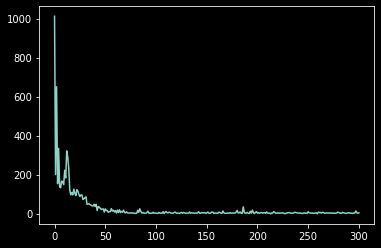

In [5]:
opt = Adam({"lr": 0.1})
svi = SVI(lr_model, lr_guide, opt, loss=Trace_ELBO())

pyro.clear_param_store()
losses = []
for j in range(301):
    loss = svi.step(data)
    losses += [loss]
    if j % 50 == 0:
        print(f"[iteration {j:04d}] loss: {loss:.3f}")
plt.plot(losses)

In [6]:
params = pyro.get_param_store()
param_history = {}
for name, value in params.items():
    value = value.detach().numpy()
    param_history[name] = value

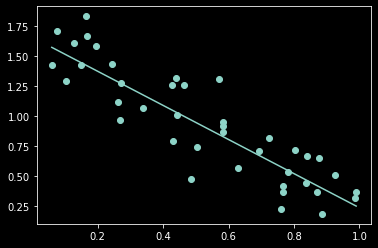

In [7]:
slope = param_history["slope_loc"]
bias = param_history["bias_loc"]
xmin, xmax = data[0].min(), data[0].max()
xd = np.linspace(xmin, xmax, 100)
yd = xd*slope + bias
plt.scatter(data[0], data[1])
plt.plot(xd, yd)

In [8]:
from pyro.infer.predictive import _predictive_sequential
from collections import defaultdict
n_samples = 500

def get_samples(foo, margs):
    trace = _predictive_sequential(
        foo,
        {},
        model_args=(),
        model_kwargs=margs,
        num_samples=n_samples,
        return_site_shapes=(),
        return_trace=True,
    )

    flat = [
        {
            k: v["value"]
            for k, v in x.nodes.items()
            if not k.startswith("_")
    #         and v["type"] != "param"
            and not v["is_observed"]
        }
        for x in trace
    ]
    post_data = defaultdict(list)

    for item in flat:
        for k in item:
            post_data[k] += [item[k]]
    return post_data

In [9]:
prior_sample = get_samples(lr_model, {"data": data})
post_sample = get_samples(lr_guide, {"data": data})

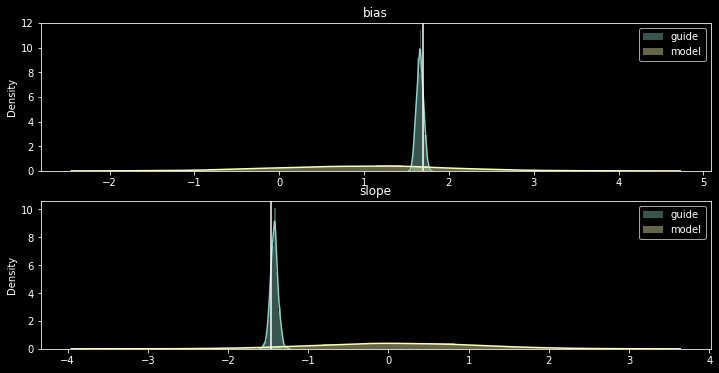

In [10]:
kkeys = sorted(prior_sample.keys())
fig, axs = plt.subplots(len(prior_sample), 1, figsize=(12, 3*len(kkeys)))
for k, ax in zip(kkeys, axs):
    sns.distplot(post_sample[k], ax=ax, label='guide')
    sns.distplot(prior_sample[k], label='model', ax=ax)
    ax.set_title(f'{k}')
    ax.axvline(gen_data_par[k])
    ax.legend()